# RTML lab2 report - st121413

1. Create VSCode projects for each of these three networks. Be sure to properly define your Python classes, with one class per file and a main module that sets up your objects, runs the training process, and saves the necessary data.

2. Note that the AlexNet implementation here does not have the local response normalization feature described in the paper. Take a look at the PyTorch implementation of LRN and incorporate it into your AlexNet implementation as it is described in the paper. Compare your test set results with and without LRN.

3. Note that the backbone of the GoogLeNet implemented thus far does not correspond exactly to the description. Modify the architecture to
 - A.Use the same backbone (input image size, convolutions, etc.) before the first Inception module
 - B. Add the two side classifiers 
 
4. Compare your GoogLeNet and AlexNet implementations on CIFAR-10. Comment on the number of parameters, speed of training, and accuracy of the two models on this dataset when trained from scratch.

5. Experiment with the pretrained GoogLeNet from the torchvision repository. Does it give better results on CIFAR-10 similar to what we found with AlexNet last week? Comment on what we can glean from the results about the capacity and generalization ability of these two models.

In [71]:
##### Prerequisite code ####### 

# import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import torch
import torchvision
from torchvision import datasets, models, transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=0)

import numpy as np
classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))


def CIFARTest(model,testloader):
    model.eval()
    #Testing Accuracy
    correct = 0
    total = 0
    #Testing classification accuracy for individual classes.
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # print(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


Files already downloaded and verified


## 1. Create VSCode projects for each of these three networks. 
*Be sure to properly define your Python classes, with one class per file and a main module that sets up your objects, runs the training process, and saves the necessary data.*

For this task, the  three models has the followings files
 
1. .ipynb for developing and testing
 2. .py for running nohup
 3. .out for collect result printed from nohup
 4. *loss*.txt and *val*.txt for collect loss in pickle format
 5. .pth the best model so far (not in Git because of size)
 6. myModule.py if that model develop using extend from python module

https://github.com/akraradets/2021JanRTML/tree/main/lab2


## 2. Alexnet (sequential)
Take a look at the PyTorch implementation of LRN and incorporate it into your AlexNet implementation as it is described in the paper. Compare your test set results with and without LRN.

For this task, I used 
 - batch_size = 4
 - train/val split = [40000, 10000]
 - Preprocess: resize=256|CenterCrop=224|Norm=(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
 - Loss Function = CrossEntropyLoss() 
 - optimizer = SGD with LR=0.001|momentum=0.9
 - epoch = 10

In [ ]:
# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
alexnet_sequential = nn.Sequential(
    # Layer 1
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    ### LRN1 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 2
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    ## LRN2 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 3
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 4
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 5
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 6
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    # Layer 7
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    # Layer 8
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    # Layer 9
    nn.Linear(4096, NUM_CLASSES)
)

*During creating the report, I noticed that the training function gave ny Prof. Matt did not return accuracy and loss of both training and valiadation phase*

*It is good that I save the print text of each run in .out*

*Next time, I will create a graph more elegantly*

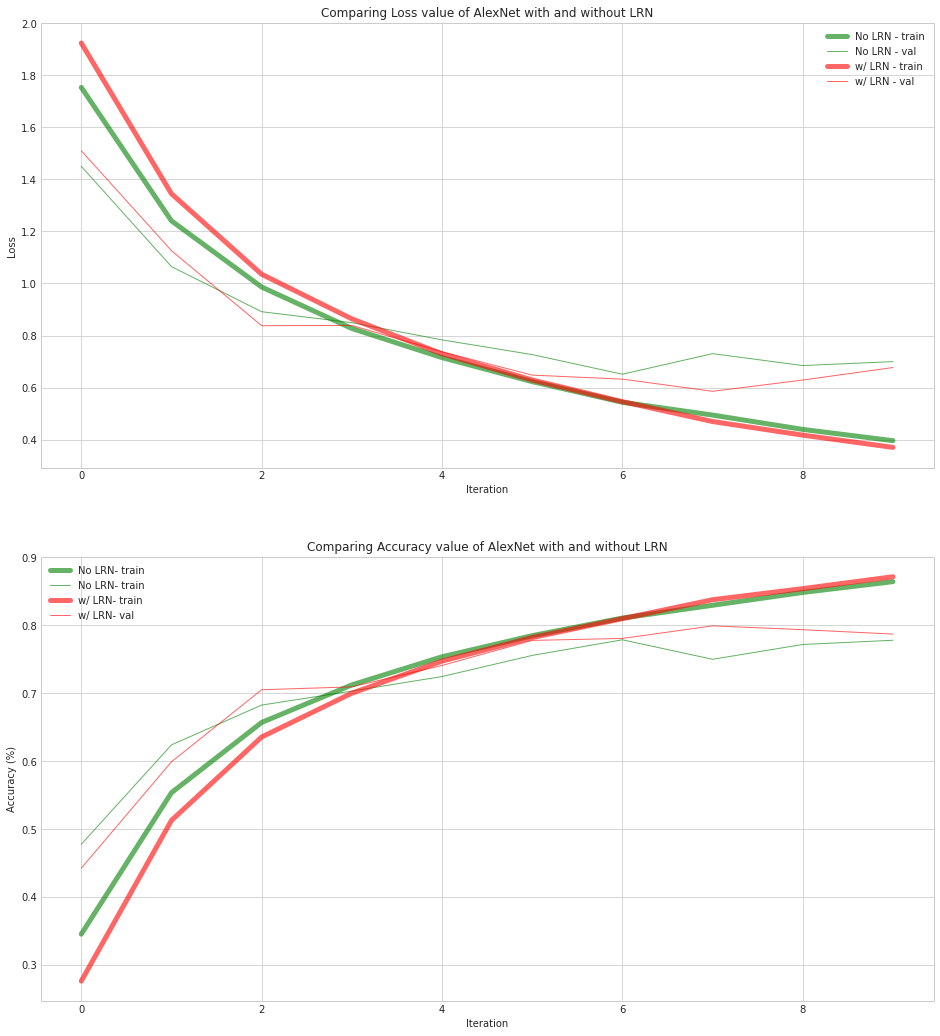

In [42]:
fig, ax = plt.subplots(2, figsize=(16,18))
##### What suppose to be elegant #######
# with open("./AlexNet/alexLRN_loss_acc_history.txt", 'rb') as handle:
#     data = pickle.load(handle)
# ax.plot(data, label="w/ LRN - train loss", c='g', lw=5, alpha=0.6)

# with open("./AlexNet/alexLRN_val_acc_history.txt", 'rb') as handle:
#     data = pickle.load(handle)
# ax.plot(data, label="w/ LRN - val loss", c='g', lw=1, alpha=0.6)

alex_train_loss = [1.7535,1.2407,0.9864,0.8271,0.7152,0.6228,0.5436,0.4943,0.4392,0.3959]
alex_train_acc = [0.3455,0.5537,0.6571,0.7124,0.7538,0.7849,0.8108,0.8296,0.8485,0.8644]
alex_val_loss = [1.4502,1.0649,0.8915,0.8494,0.7833,0.7267,0.6513,0.7304,0.6846,0.6997]
alex_val_acc = [0.4778,0.6241,0.6827,0.7033,0.7247,0.7558,0.7788,0.7501,0.7719,0.7781]

alexlrn_train_loss = [1.9240,1.3448,1.0355,0.8641,0.7297,0.6292,0.5459,0.4695,0.4172,0.3702]
alexlrn_train_acc = [0.2764,0.5129,0.6357,0.7002,0.7474,0.7821,0.8099,0.8378,0.8541,0.8716]
alexlrn_val_loss = [1.5101,1.1260,0.8378,0.8388,0.7376,0.6478,0.6325,0.5856,0.6289,0.6770]
alexlrn_val_acc = [0.4426,0.5992,0.7053,0.7095,0.7410,0.7779,0.7808,0.7993,0.7937,0.7872]

ax[0].plot(alex_train_loss, label="No LRN - train", c='g', lw=5, alpha=0.6)
ax[0].plot(alex_val_loss, label="No LRN - val", c='g', lw=1, alpha=0.6)
ax[0].plot(alexlrn_train_loss, label="w/ LRN - train", c='r', lw=5, alpha=0.6)
ax[0].plot(alexlrn_val_loss, label="w/ LRN - val", c='r', lw=1, alpha=0.6)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Comparing Loss value of AlexNet with and without LRN')
ax[0].legend()

ax[1].plot(alex_train_acc, label="No LRN- train", c='g', lw=5, alpha=0.6)
ax[1].plot(alex_val_acc, label="No LRN- train", c='g', lw=1, alpha=0.6)
ax[1].plot(alexlrn_train_acc, label="w/ LRN- train", c='r', lw=5, alpha=0.6)
ax[1].plot(alexlrn_val_acc, label="w/ LRN- val", c='r', lw=1, alpha=0.6)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Comparing Accuracy value of AlexNet with and without LRN')
ax[1].legend()

plt.show()




In [77]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
model = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, NUM_CLASSES)
)
model.load_state_dict(torch.load('./AlexNet/alex_sequential_lr_0.001_bestsofar.pth'))
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 78 %
Accuracy of plane : 78 %
Accuracy of   car : 90 %
Accuracy of  bird : 69 %
Accuracy of   cat : 66 %
Accuracy of  deer : 80 %
Accuracy of   dog : 64 %
Accuracy of  frog : 85 %
Accuracy of horse : 82 %
Accuracy of  ship : 81 %
Accuracy of truck : 85 %


In [75]:

# AlexNet-like model using the Sequential API
NUM_CLASSES = 10
model = nn.Sequential(
    # Layer 1
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    ### LRN1 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 2
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    ## LRN2 ###
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 3
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 4
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Layer 5
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Layer 6
    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    # Layer 7
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    # Layer 8
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    # Layer 9
    nn.Linear(4096, NUM_CLASSES)
)
model.load_state_dict( torch.load('./AlexNet/alex_sequential_LRN_lr_0.001_bestsofar.pth'), strict=False)
model.eval()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

CIFARTest(model,testloader)

Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 65 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 64 %
Accuracy of  frog : 85 %
Accuracy of horse : 84 %
Accuracy of  ship : 86 %
Accuracy of truck : 86 %


Last but not least.

- Training time of AlexNet with out LRN is  28m 33s
- Training time of AlexNet with LRN is      31m 15s


Conclusion: The 1-2% gain in accuracy and complexity increase is seem to be the same as the paper